# 08 - 工具变量

## 规避遗漏变量偏差

控制遗漏变量偏差（OVB）的一种方法是直接将遗漏变量加入模型中。然而，这并非总是可行，主要原因在于我们往往缺乏关于遗漏变量的数据。例如，回到我们关于教育对工资影响的模型：

$
\log(\mathrm{wage})_i = \beta_0 + \kappa \ \mathrm{educ}_i + \pmb{\beta}\mathrm{Ability}_i + u_i
$

要确定教育 $\kappa$ 对 $\log\mathrm{(wage)}$  的因果效应，我们需要控制能力因素 $\mathrm{Ability}_i$。若不这样做，很可能会产生偏差，毕竟能力很可能是一个混杂因素，既影响处理变量（教育），也影响结果变量（收入）。

In [34]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

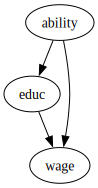

In [36]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

避免这一问题的一种方法是在衡量教育对工资影响时，控制能力水平的恒定。我们可以通过在线性回归模型中纳入能力变量来实现这一点。然而，我们缺乏对能力的良好测量指标。目前最好的替代是一些非常存疑的代理变量，比如智商。

但并非全无希望。这时工具变量（Instrumental Variables）便派上用场。IV 的核心思想是找到另一个变量，该变量能影响处理变量，且仅通过处理变量与结果相关。换言之，该工具变量 $Z_i$ 与 $Y_0$ 不相关，但与 $T$ 相关。这一条件有时被称为排他性约束。

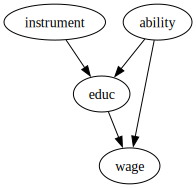

In [39]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

若存在这样的变量，我们便可通过即将介绍的 IV 公式还原因果效应 $\kappa$。为此，让我们先构想理想情况下希望建立的方程。使用更通用的术语，如以 $T$ 表示处理变量、$W$  表示混杂因素，我们期望的模型如下：

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

然而，我们缺乏关于 $W$ 的数据，因此实际只能建立如下模型：

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

由于 $W$ 是一个混杂因素，$\mathrm{Cov}(T, v) \neq 0$。我们有一个简短而非冗长的方程。在我们的例子中，这意味着能力与教育程度相关。如果情况如此，运行短回归将由于遗漏变量而对 $\kappa$ 产生有偏估计。

现在，见证工具变量（IV）的神奇之处！由于工具 Z 仅通过 T 与结果相关，这意味着 $\mathrm{Cov}(Z,v) = 0$，否则会存在第二条从 Z 到 Y 通过 W 的路径。考虑到这一点，我们可以写出

$
\mathrm{Cov}(Z,Y) = \mathrm{Cov}(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa \mathrm{Cov}(Z,T) + \mathrm{Cov}(Z, v) = \kappa \mathrm{Cov}(Z,T)
$

两边同时除以 $V(Z_i)$ 并重新排列各项后，我们得到

$
\kappa = \dfrac{\mathrm{Cov}(Y_i, Z_i)/V(Z_i)}{\mathrm{Cov}(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

注意分子和分母都是回归系数（协方差除以方差）。分子是 Y 对 Z 回归的结果。换句话说，这是 Z 对 Y 的“影响”。记住，这并不是说 Z 导致了 Y，因为我们有要求 Z 仅通过 T 影响 Y。相反，它仅捕捉了 Z 通过 T 对 Y 的影响有多大。这个分子非常著名，甚至有自己的名字：简化形式系数。

分母同样是一个回归系数，但此处表示的是 T 对 Z 的回归。这一回归捕捉了 Z 对 T 的影响，因其重要性而被广泛称为第一阶段系数。

理解该方程的另一个巧妙方式是通过偏导数的视角。我们可以证明 T 对 Y 的影响等于 Z 对 Y 的影响，按 Z 对 T 的影响进行缩放：

$
\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{\partial z}{\partial T} =  \dfrac{\partial y}{\partial T}
$

这一公式揭示的内涵比多数人理解的更为精妙，其精妙程度也远超普遍认知。通过工具变量（IV）的这种表述方式，我们实际上在表达：“由于混杂因素的存在，直接测量 T 对 Y 的影响十分困难。但 Z 对 Y 的影响则易于获取，因为 Z 与 Y 之间不存在共同成因（排他性约束）。然而，我们真正关注的是 T 而非 Z 对 Y 的效应。因此，我将先估算 Z 对 Y 的简易效应，再**通过 Z 对 T 的效应进行尺度转换**，从而将效应单位从 Z 转换为 T。”

在工具变量为虚拟变量的简化情形中，我们还能看到工具变量估计量进一步简化为两组均值差的比值。

$
\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

这一比率有时被称为 **沃尔德估计量（Wald Estimator）**。重申一下，我们可以通过工具变量（IV）的故事来理解：我们关注的是 T 对 Y 的影响，这难以直接获取，因此转而研究 Z 对 Y 的效应，后者更为容易。根据定义，Z 仅通过 T 影响 Y，因此我们可以将 Z 对 Y 的作用转化为 T 对 Y 的作用。具体方法是将 Z 对 Y 的效应按 Z 对 T 的效应比例进行缩放。

## 出生季度与教育对工资的影响

迄今为止，我们一直将这些工具变量视为某种神奇变量 $Z$，它们拥有仅通过处理变量影响结果的奇妙特性。坦白说，优质工具变量如此难寻，几乎可被视为奇迹。可以说，这绝非胆小者所能轻易尝试。传闻中，芝加哥经济学院的精英们常在酒吧里讨论他们是如何灵光一现想出这样或那样的工具变量。 

![img](./images/08/good-iv.png)

不过，我们确实有一些有趣的工具变量例子，可以让事情更具体一些。我们将再次尝试估计教育对工资的影响。为此，我们将使用个人的出生季度作为工具变量 Z。

这一观点利用了美国的义务教育法。通常，法律规定孩子在入学年份的 1 月 1 日之前必须年满 6 岁。因此，年初出生的孩子入学时年龄会更大。义务教育法还要求学生必须在校学习直至 16 岁，届时他们可以合法辍学。结果是，平均而言，一年中较晚出生的孩子比年初出生的孩子接受教育的年限更长。

![img](./images/08/qob.png)

如果我们承认出生季度与能力因素无关，即它不会混淆教育对工资的影响，那么我们可以将其作为工具变量。换句话说，我们需要相信出生季度除了通过影响教育外，对工资没有其他影响。如果你不相信占星术，这是一个非常有说服力的论点。

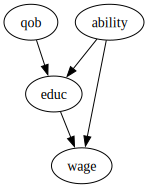

In [42]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

为了进行这一分析，我们可以使用来自三次十年一度的人口普查数据，这些数据与[Angrist and Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991)在其关于工具变量的文章中所使用的相同。该数据集包含对数工资（我们的结果变量）和受教育年限（我们的处理变量）的信息。此外，它还提供了出生季度（我们的工具变量）以及其他控制变量，如出生年份和出生州的数据。

In [45]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## 第一阶段

在使用出生季度作为工具变量前，我们必须确保其有效性。这意味着需要论证支持工具变量的两个假设条件：

1. $\mathrm{Cov}(Z, T) \neq 0$。这表明我们应具备强第一阶段，即工具变量确实能影响处理变量。
2. $Y \perp Z | T $。这就是排他性约束，表明工具变量 Z 仅通过处理 T 影响结果 Y。 

幸运的是，第一个假设是可验证的。从数据中我们可以看出 $\mathrm{Cov}(Z, T)$ 不为零。在我们的例子中，如果出生季度确实如我们所说的那样是一个工具变量，那么我们应该预期出生在一年最后一季度的人比年初出生的人受教育时间略长。在运行任何统计检验来验证这一点之前，让我们先绘制数据并用肉眼观察。

In [52]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

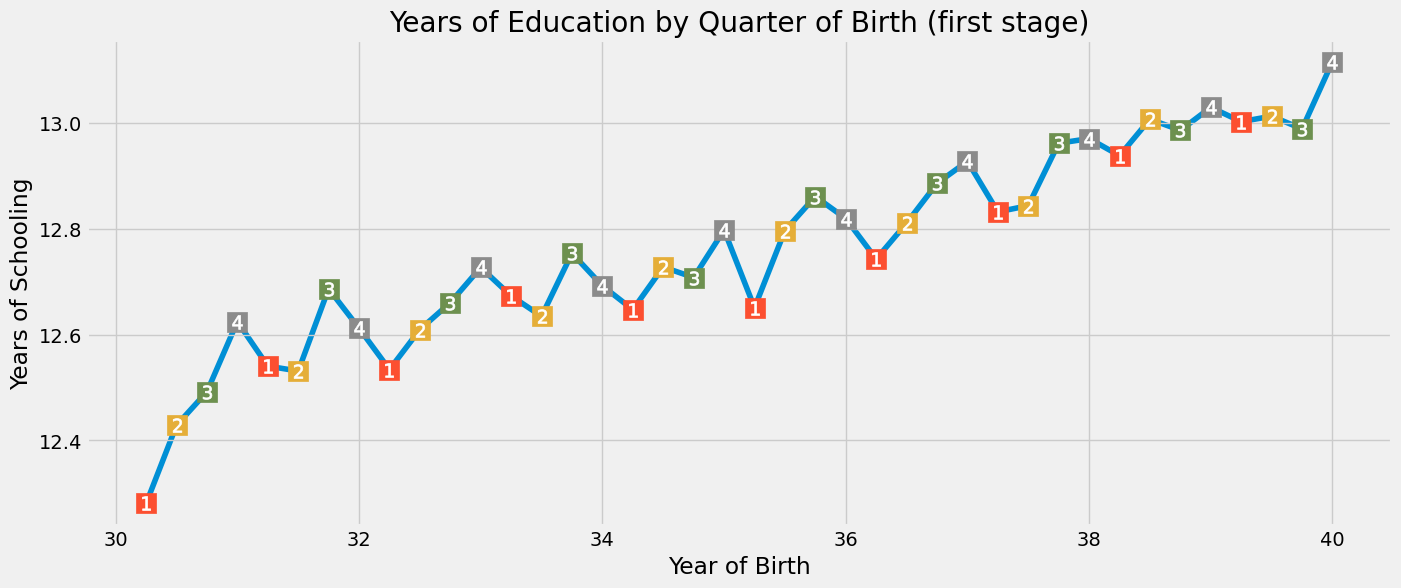

In [58]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling")
plt.show() ;

值得注意的是，受教育年限存在与出生季度相符的季节性模式。从视觉上看，我们可以发现，出生在一年第一季度的人几乎总是比最后一季度出生的人受教育程度低（毕竟，在控制了出生年份后，一般来说，出生年份较晚的人受教育程度更高）。

为了更加严谨，我们可以将第一阶段作为线性回归来运行。首先，我们将出生季度转换为虚拟变量：

In [61]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


为简化起见，我们暂且仅使用最后一个季度（第四季度）作为工具变量。我们将对受教育年限（处理变量）与出生季度（工具变量）进行回归分析，以验证是否如前述图表所示，出生季度确实对教育时长产生正向影响。在此过程中，还需控制出生年份，并额外加入出生州作为控制变量。

In [64]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272785526
q4 p-value:,  5.4648294166544506e-15


数据显示，相较于其他季度出生的人群，年末第四季度出生者平均多接受 0.1 年的教育，且 p 值趋近于零。这为"出生季度是否导致受教育年限差异"的争论提供了明确结论。

![img](./images/08/incomplete-files.png)

## 简化形式

遗憾的是，我们无法验证第二个工具变量（IV）条件，只能为其合理性进行辩护。我们可以表达这样一种信念：出生季度不会影响潜在收入。换言之，除教育影响外，人们的出生时间并不能反映其个人能力或其他可能导致收入差异的因素。一个有力的论证方式是说明，当我们考虑出生季度对收入的影响时，其分配效果近乎随机（实际上并非真正随机。有证据表明人们倾向于在夏末或某些节假日前后受孕。但我无法想象这种模式会通过教育以外的任何途径影响收入）。

在论证了排除限制条件的合理性后，我们可以着手进行简化形式的分析。简化形式旨在揭示工具变量如何影响结果变量。根据假设，这种影响完全通过对处理变量的作用实现，从而间接展现处理变量对结果变量的影响机制。让我们再次通过可视化评估这一关系，然后再进行严谨的回归分析。

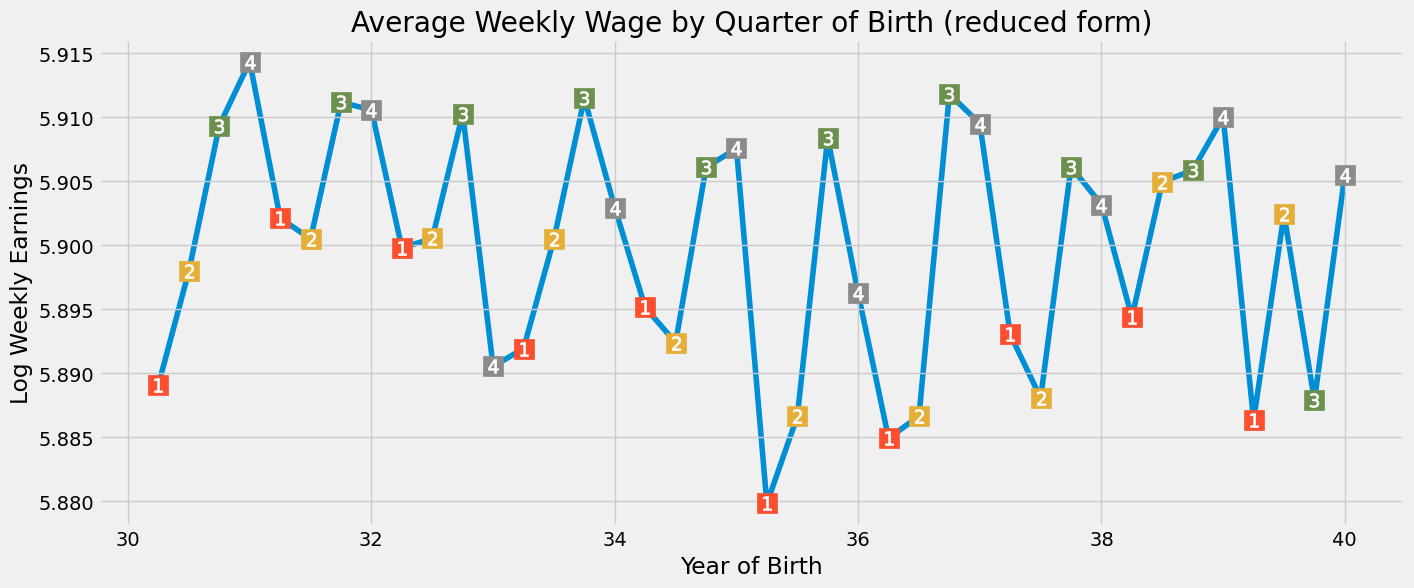

In [71]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings")
plt.show();

我们再次观察到按出生季度划分的收入呈现季节性模式。年末出生者的收入略高于年初出生者。为验证这一假设，我们将再次对工具变量 q4 与对数工资进行回归分析，并如第一阶段那样加入相同的额外控制变量：

In [73]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260150531
q4 p-value:,  0.001494912718345724


我们再次得到了一个显著的结果。那些在一年最后三个月出生的人，平均工资要高出 0.8%。这次的 p 值虽然不像之前那样接近于零，但仍然相当显著，仅为 0.0015。

## 手工操作工具变量

既然我们已经有了简化形式和第一阶段的结果，现在可以通过简化形式来缩放第一阶段的影响。由于第一阶段的系数大约是 0.1，这将使简化形式系数的影响几乎放大 10 倍。这将为我们提供无偏的工具变量估计，即平均因果效应：

$
\mathrm{ATE}_{IV} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

In [75]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492096631

这意味着，我们预计每多接受一年教育，工资将增加 8%。

另一种获取工具变量估计值的方法是采用两阶段最小二乘法（**2SLS**）。按照这一程序，我们首先进行与之前相同的第一阶段操作，然后在第二阶段中将处理变量替换为第一阶段的拟合值。

$
\mathrm{educ}_i = \gamma_0 + \gamma_1 \times \mathrm{q4}_i + \gamma_2\times \mathrm{yob}_i + \gamma_3\times \mathrm{sob}_i + v_i
$

$
\log(\mathrm{wage})_i = \beta_0 + \beta_1\times \mathrm{educ}_i + \beta_2\times \mathrm{yob}_i + \beta_3\times \mathrm{sob}_i + u_i
$

$
\log(\mathrm{wage})_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 \times \mathrm{q4}_i + \gamma_2\times \mathrm{yob}_i + \gamma_3\times \mathrm{sob}_i + v_i ]  + \beta_2\times \mathrm{yob}_i + \beta_3\times \mathrm{sob}_i + u_i
$

需要注意的是，**在实施工具变量法时，我们对第二阶段添加的任何额外控制变量也应同样添加到第一阶段**。

In [78]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286491929225

如您所见，这些参数完全一致。从直觉角度出发，这种理解工具变量（IV）的第二方式颇具启发性。在两阶段最小二乘法（2SLS）中，第一阶段会生成一个经过遗漏变量偏差净化处理的新治疗变量版本。随后，我们在线性回归中使用这一净化后的治疗变量——即第一阶段的拟合值。

然而实际操作中，我们并不手动进行工具变量分析。并非因其繁琐，而是由于第二阶段所得标准误存在些许偏差。正确的做法是始终让计算机代劳。在 Python 中，我们可以借助 [linearmodels](https://bashtage.github.io/linearmodels/) 库以规范方式运行 2SLS。

2SLS 的公式设定略有不同。我们需在公式内的方括号\[\]间加入第一阶段。本例中我们添加 `years_of_schooling ~ q4` 。额外控制变量无需显式加入第一阶段，因为只要它们在第二阶段被包含，计算机会自动处理。因此，我们将 `year_of_birth` 和 `state_of_birth` 置于第一阶段公式之外。

In [86]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.0853028649110826
SE: 0.025540812817820696
95 CI: [0.03524287 0.13536286]
P-value: 0.000838191468812699


再次可见，该参数与我们之前所得完全一致。额外的优势在于，我们现在拥有了有效的标准误差。基于此，可以说，我们预计平均每多接受一年教育，工资将增长 8.5%。

## 多重工具变量

利用计算机运行 2SLS 的另一项优势在于，能够便捷地引入多重工具变量。在本例中，我们将所有出生季度的虚拟变量作为教育年限的工具变量使用。

In [88]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370486966799
SE: 0.01955714900793806
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


在包含所有三个虚拟变量的情况下，教育回报的估计值现为 0.1，这意味着每多接受一年教育，我们预期收入平均将增加 10%。让我们将此与传统 OLS 估计进行比较。为此，我们可以再次使用 2SLS，但这次无需第一阶段。

In [91]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817657356
SE: 0.00038839984390487154
95 CI: [0.06656446 0.06808699]
P-value: 0.0


教育回报率的估计值在普通最小二乘法（OLS）中低于两阶段最小二乘法（2SLS）。这表明遗漏变量偏差（OVB）可能不如最初设想的那样严重。同时，注意置信区间的差异：2SLS 的置信区间较 OLS 估计值显著更宽。我们将进一步探讨这一现象。

## 工具变量的弱点

![img](./images/08/weak-iv.png)

在使用工具变量（IV）时，需谨记我们是在间接估计平均处理效应（ATE）。估计结果同时依赖于第一阶段和第二阶段。若处理对结果的影响确实强烈，第二阶段也会表现强劲。然而，若第一阶段薄弱，无论第二阶段多强都无济于事。薄弱的第一阶段意味着工具变量与处理仅存在极微弱的相关性，因此我们无法通过工具变量获取关于处理的足够信息。

工具变量标准误的公式较为复杂且不够直观，为此我们将采用其他方法理解该问题。我们将模拟一组数据：处理变量 T 对结果 Y 具有 2.0 的效应，存在未观测混杂因素 U 及额外控制变量 X，并模拟多个第一阶段强度不同的工具变量。

$$
\begin{align}
X \sim & N(0, 2^2)\\
U \sim & N(0, 2^2)\\
T \sim & N(1+0.5U, 5^2)\\
Y \sim & N(2+ X - 0.5U + 2T, 5^2)\\
Z \sim & N(T, \sigma^2) \text{ for }\sigma^2 \text{ in 0.1 to 100}
\end{align}
$$

In [94]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing \mathrm{Cov}(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,...,Z_48,Z_49
0,2.696148,8.056988,...,-117.798705,-13.485292
1,2.570240,0.245067,...,-209.727577,-70.792948
2,0.664741,5.597510,...,60.562232,47.619414
3,1.037725,0.493532,...,78.136513,-108.322304
4,-2.590591,-6.263014,...,78.776566,-80.547214


只是为了再次确认，我们可以看到 Z 和 T 之间的相关性确实在下降。

In [97]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

现在，我们将为每种工具运行一个 IV 模型，并收集 ATE 估计值和标准误差。

In [100]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

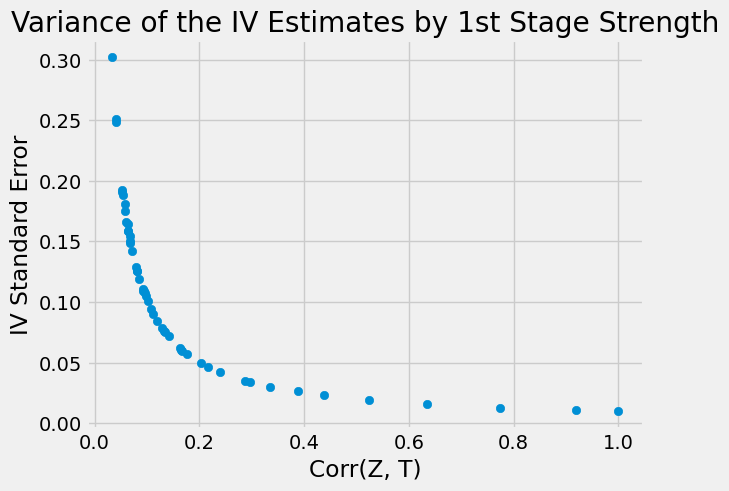

In [112]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength")
plt.show() ;

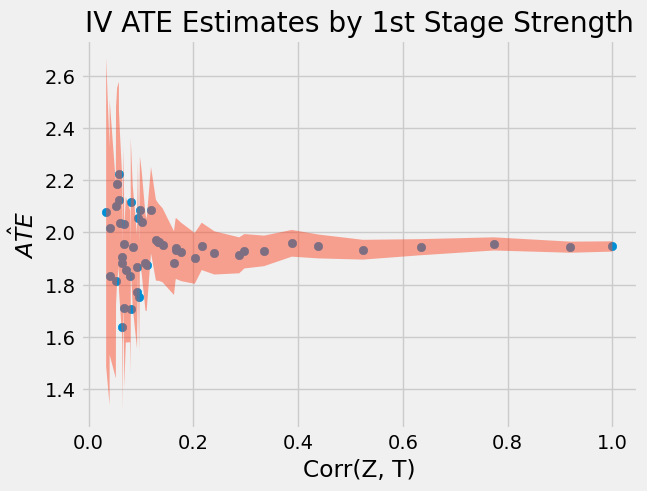

In [120]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength")
plt.show();

如上图所示，当 T 与 Z 之间的相关性较弱时，估计值波动极大。这是因为在相关性较低的情况下，标准误（SE）也会显著增加。

另一个需要注意的现象是，**两阶段最小二乘法（2SLS）存在偏差**！即便在高度相关的情况下，参数估计值仍未达到真实平均处理效应（ATE）2.0。实际上，2.0 甚至不在 95%置信区间内！2SLS 仅具有一致性，这意味着当样本量足够大时，它会趋近于真实参数值。然而，我们无法确切知道“足够大”的具体标准，只能依据经验法则来理解这种偏差的表现规律：

1. 2SLS 的偏差方向与普通最小二乘法（OLS）相同。即若 OLS 存在负/正偏差，2SLS 也会呈现相同偏差。2SLS 的优势在于，在存在遗漏变量的情况下，它至少具有一致性（而 OLS 不具备）。上例中，未观测变量 U 对结果产生负向影响，但与处理变量正相关，这将导致负偏差。因此我们看到的 ATE 估计值低于真实值（负偏差）。

2. 偏差会随着工具变量数量的增加而增大。若添加过多工具变量，2SLS 会越来越接近 OLS 的估计结果。

除了理解这种偏差的特性外，最后还要提醒**在实施工具变量法时应避免以下常见错误**：

1. 手动进行工具变量（IV）分析。正如我们所观察到的，手动操作 IV 虽可能得到正确的参数估计，但标准误差（SE）会出错。标准误差虽不至于完全偏离，但既然使用软件能获得准确的 SE，何必手动冒险？

2. 在第一阶段采用非普通最小二乘法（OLS）的其他方法。许多数据科学家接触工具变量时，常自信能优化传统做法。例如，面对虚拟处理变量时，他们可能考虑用逻辑回归替代第一阶段的 OLS，毕竟是在预测二元变量，对吧？问题在于这种做法根本错误。IV 的稳健性依赖于 OLS 独有的残差正交特性，任何非 OLS 的第一阶段方法都将导致估计偏差。（注：虽有现代技术尝试将机器学习应用于 IV，但其效果至今最多只能说是存疑）。

## 核心要点

我们在此花费了一些时间来探讨，在拥有工具变量的情况下如何规避遗漏变量偏差。工具变量是指与处理变量相关（存在第一阶段效应），但仅通过处理变量影响结果（满足排他性约束）的变量。我们以出生季度作为工具变量来估计教育对收入影响的例子进行了说明。

随后我们深入研究了利用工具变量（IV）估计因果效应的机制，即采用两阶段最小二乘法（2SLS）。同时我们也认识到，工具变量并非万能良药。当第一阶段效应较弱时，该方法可能带来较大困扰。此外，尽管 2SLS 具有一致性，但它仍是一种存在偏差的因果效应估计方法。




## 致谢
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 贡献
《因果推断：献给求真敢为者》是一份关于因果推断的开源材料，属于科学统计领域。它仅基于 Python 使用免费软件，旨在实现经济与智力上的双重可及性。若您认为此书有价值并希望支持，请前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)。若暂无法经济支持，您也可以通过修正拼写错误、建议修改或对不理解的内容提供反馈来帮助改进。只需访问书籍仓库并提交问题。最后，若您喜欢此内容，请分享给可能受益的人，并在 GitHub 上为其加星。